# VAE

In [2]:
from __future__ import print_function
import argparse
import torch
import torch.utils.data
from torch import nn, optim
from torch.nn import functional as F
from torchvision import datasets, transforms
from torchvision.utils import save_image
import pandas as pd
import utils
from utils import PROJECT_ROOT, DATA_PATH
import yuval_module.paper_source as PaperSource
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
#sttings
batch_size= 8
epochs= 2
cuda= torch.cuda.is_available()
seed= 42
log_interval= 10
num_workers= 2

In [4]:
#check for cuda
device = torch.device('cuda' if cuda else 'cpu')
device

device(type='cpu')

In [5]:
torch.manual_seed(seed)


In [6]:
kwargs = {'num_workers': 1, 'pin_memory': True} if cuda else {}

In [7]:
from torch.utils.data import Dataset, DataLoader

In [8]:
import py_4.get_mesh_vec as get_mesh_vec

In [9]:
mesh_embed=get_mesh_vec.MeshEmbeddings()

In [10]:
FILE = "enriched_labeled_dataset_large.json" 
if os.path.exists(PROJECT_ROOT + DATA_PATH + FILE):
    print("READING FROM LOCAL")
    if FILE.split(".")[1] == "json":
        df = pd.read_json(PROJECT_ROOT + DATA_PATH + FILE)
    else:
        df = pd.read_csv(PROJECT_ROOT + DATA_PATH + FILE)
    #ps = PaperSource()
else:
    print("PULLING FROM S3")
    ps = sim_matrix_3.load_dataset("enriched_labeled_dataset")
    df = ps.get_dataset()

df.drop(columns=["last_author_country"],inplace=True)
df.rename(columns={'ORG_STATE':'last_author_country'},inplace=True)

print("FILE PULLED")

READING FROM LOCAL
FILE PULLED


In [11]:
mesh_embed.get_feat_mesh(df[:20].mesh.to_list()).shape

MESH NAME NOT FOUND: Male
MESH NAME NOT FOUND: Female
MESH NAME NOT FOUND: Female
MESH NAME NOT FOUND: Male
MESH NAME NOT FOUND: Male
MESH NAME NOT FOUND: Male
MESH NAME NOT FOUND: Male
MESH NAME NOT FOUND: Male
MESH NAME NOT FOUND: Female
MESH NAME NOT FOUND: Male
MESH NAME NOT FOUND: Male
MESH NAME NOT FOUND: Female
MESH NAME NOT FOUND: Male
MESH NAME NOT FOUND: Male
MESH NAME NOT FOUND: Female
MESH NAME NOT FOUND: Male
MESH NAME NOT FOUND: Male


(20, 64)

In [12]:
selection=['8352708','6913641']
PI_lst=df.PI_IDS[df.PI_IDS.isin(selection)].to_list()

In [81]:
class ToyDS(Dataset):
    def __init__(self,df):
        super().__init__()
        self.df = mesh_embed.get_feat_mesh(df[:10000].mesh.to_list())
        #self.df = mesh_embed.get_feat_mesh(df[df.PI_IDS.isin(selection)].mesh.to_list()) 

        
 
    def __len__(self):
        return self.df.shape[0]
    
    def __getitem__(self, idx):
        features= self.df[idx]
        return features, features

In [82]:
train_set = ToyDS(df)
train_loader=DataLoader(dataset= train_set, batch_size = batch_size, shuffle = True, num_workers = num_workers)

T FOUND: Female
MESH NAME NOT FOUND: Male
MESH NAME NOT FOUND: Female
MESH NAME NOT FOUND: Female
MESH NAME NOT FOUND: Male
MESH NAME NOT FOUND: Female
MESH NAME NOT FOUND: Male
MESH NAME NOT FOUND: Male
MESH NAME NOT FOUND: Male
MESH NAME NOT FOUND: Male
MESH NAME NOT FOUND: Female
MESH NAME NOT FOUND: Male
MESH NAME NOT FOUND: Male
MESH NAME NOT FOUND: Female
MESH NAME NOT FOUND: Male
MESH NAME NOT FOUND: Female
MESH NAME NOT FOUND: Female
MESH NAME NOT FOUND: Male
MESH NAME NOT FOUND: Female
MESH NAME NOT FOUND: Male
MESH NAME NOT FOUND: Female
MESH NAME NOT FOUND: Female
MESH NAME NOT FOUND: Male
MESH NAME NOT FOUND: Female
MESH NAME NOT FOUND: Male
MESH NAME NOT FOUND: Female
MESH NAME NOT FOUND: Male
MESH NAME NOT FOUND: Female
MESH NAME NOT FOUND: Female
MESH NAME NOT FOUND: Female
MESH NAME NOT FOUND: Male
MESH NAME NOT FOUND: Chlorocebus aethiops
MESH NAME NOT FOUND: Female
MESH NAME NOT FOUND: Male
MESH NAME NOT FOUND: Female
MESH NAME NOT FOUND: Male
MESH NAME NOT FOUND: Fem

In [83]:
class VAE(nn.Module):
    def __init__(self, input_dim = 64):
        super(VAE, self).__init__()
        self.input_dim = input_dim
        self.fc1 = nn.Linear(self.input_dim, 32)
        self.fc21 = nn.Linear(32, 8)
        self.fc22 = nn.Linear(32, 8)
        self.fc3 = nn.Linear(8, 32)
        self.fc4 = nn.Linear(32, self.input_dim)

    def encode(self, x):
        h1 = F.relu(self.fc1(x))
        return self.fc21(h1), self.fc22(h1)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std

    def decode(self, z):
        h3 = F.relu(self.fc3(z))
        return torch.sigmoid(self.fc4(h3))

    def forward(self, x):
        mu, logvar = self.encode(x.view(-1, self.input_dim))
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar, z

In [84]:
def loss_function(recon_x, x, mu, logvar):
    #BCE = F.binary_cross_entropy(recon_x, x.view(-1, 64), reduction='sum')

    MSE = F.mse_loss(recon_x, x.view(-1, 64))

    # see Appendix B from VAE paper:
    # Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
    # https://arxiv.org/abs/1312.6114
    # 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    return MSE + KLD

In [85]:
model = VAE().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)


In [86]:
from torchsummary import summary
summary(model, (20,64))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                   [-1, 32]           2,080
            Linear-2                    [-1, 8]             264
            Linear-3                    [-1, 8]             264
            Linear-4                   [-1, 32]             288
            Linear-5                   [-1, 64]           2,112
Total params: 5,008
Trainable params: 5,008
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.02
Estimated Total Size (MB): 0.03
----------------------------------------------------------------


In [87]:
import numpy as np

In [88]:
def train_epoch(tr_loader, model, criterion, optimizer, num_epochs):
    model.train()
    train_log = []
    
    for epoch in range(num_epochs):
        bottle_neck=[]
        print("Started training epoch no. {}",format(epoch+1))
        train_loss= 0
        for batch_idx, (data, _) in enumerate(train_loader):
            data = data.to(device, dtype=torch.float32)

            optimizer.zero_grad()
            recon_batch, mu, logvar, z= model(data)
            bottle_neck.extend(z.detach().numpy())
            loss = criterion(recon_batch, data, mu, logvar)
            loss.backward()
            train_loss += loss.item()
            optimizer.step()
            if batch_idx % log_interval == 0:
                print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                    epoch, batch_idx * len(data), len(train_loader.dataset),
                    100. * batch_idx / len(train_loader),
                    loss.item() / len(data)))

        print('====> Epoch: {} Average loss: {:.4f}'.format(
            epoch, train_loss / len(train_loader.dataset)))
        train_log.append({
            'epoch': epoch,
            'train_loss': train_loss / len(train_loader)})
    return train_log, bottle_neck

In [89]:
# def test(epoch):
#     model.eval()
#     test_loss = 0
#     with torch.no_grad():
#         for i, (data, _) in enumerate(test_loader):
#             data = data.to(device)
#             recon_batch, mu, logvar = model(data)
#             test_loss += loss_function(recon_batch, data, mu, logvar).item()
#             if i == 0:
#                 n = min(data.size(0), 8)
#                 comparison = torch.cat([data[:n],
#                                       recon_batch.view(args.batch_size, 1, 28, 28)[:n]])
#                 save_image(comparison.cpu(),
#                          'results/reconstruction_' + str(epoch) + '.png', nrow=n)

#     test_loss /= len(test_loader.dataset)
#     print('====> Test set loss: {:.4f}'.format(test_loss))

In [90]:
train_log, bottle_neck= train_epoch(train_loader,model,loss_function,optimizer,num_epochs= 3)

Started training epoch no. {} 1
Train Epoch: 0 [0/10000 (0%)]	Loss: 0.270922
Train Epoch: 0 [80/10000 (1%)]	Loss: 0.081099
Train Epoch: 0 [160/10000 (2%)]	Loss: 0.062458
Train Epoch: 0 [240/10000 (2%)]	Loss: 0.052666
Train Epoch: 0 [320/10000 (3%)]	Loss: 0.051415
Train Epoch: 0 [400/10000 (4%)]	Loss: 0.056243
Train Epoch: 0 [480/10000 (5%)]	Loss: 0.042104
Train Epoch: 0 [560/10000 (6%)]	Loss: 0.038943
Train Epoch: 0 [640/10000 (6%)]	Loss: 0.037639
Train Epoch: 0 [720/10000 (7%)]	Loss: 0.038871
Train Epoch: 0 [800/10000 (8%)]	Loss: 0.025881
Train Epoch: 0 [880/10000 (9%)]	Loss: 0.029788
Train Epoch: 0 [960/10000 (10%)]	Loss: 0.035745
Train Epoch: 0 [1040/10000 (10%)]	Loss: 0.029415
Train Epoch: 0 [1120/10000 (11%)]	Loss: 0.024177
Train Epoch: 0 [1200/10000 (12%)]	Loss: 0.021878
Train Epoch: 0 [1280/10000 (13%)]	Loss: 0.020082
Train Epoch: 0 [1360/10000 (14%)]	Loss: 0.027562
Train Epoch: 0 [1440/10000 (14%)]	Loss: 0.016533
Train Epoch: 0 [1520/10000 (15%)]	Loss: 0.018412
Train Epoch: 0 [

In [91]:
len(bottle_neck)

10000

# Test

In [92]:
test_set = ToyDS(df[df.PI_IDS.isin(selection)])
test_loader=DataLoader(dataset= test_set, batch_size = batch_size, shuffle = True, num_workers = num_workers)

MESH NAME NOT FOUND: Male
MESH NAME NOT FOUND: Female
MESH NAME NOT FOUND: Female
MESH NAME NOT FOUND: Male
MESH NAME NOT FOUND: Male
MESH NAME NOT FOUND: Male
MESH NAME NOT FOUND: Male
MESH NAME NOT FOUND: Male
MESH NAME NOT FOUND: Female
MESH NAME NOT FOUND: Male
MESH NAME NOT FOUND: Male
MESH NAME NOT FOUND: Female
MESH NAME NOT FOUND: Male
MESH NAME NOT FOUND: Male
MESH NAME NOT FOUND: Female
MESH NAME NOT FOUND: Male
MESH NAME NOT FOUND: Male
MESH NAME NOT FOUND: Male
MESH NAME NOT FOUND: Male
MESH NAME NOT FOUND: Female
MESH NAME NOT FOUND: Female
MESH NAME NOT FOUND: Male
MESH NAME NOT FOUND: Female
MESH NAME NOT FOUND: Male
MESH NAME NOT FOUND: Female
MESH NAME NOT FOUND: Female
MESH NAME NOT FOUND: Male
MESH NAME NOT FOUND: Male
MESH NAME NOT FOUND: Female
MESH NAME NOT FOUND: Male
MESH NAME NOT FOUND: Female
MESH NAME NOT FOUND: Male
MESH NAME NOT FOUND: Female
MESH NAME NOT FOUND: Male
MESH NAME NOT FOUND: Female
MESH NAME NOT FOUND: Male
MESH NAME NOT FOUND: Male
MESH NAME 

In [93]:
bottle_neck=[]
for batch_idx, (data, _) in enumerate(test_loader):
            data = data.to(device, dtype=torch.float32)
            optimizer.zero_grad()
            recon_batch, mu, logvar, z= model(data)
            bottle_neck.extend(z.detach().numpy())

In [94]:
bottle_neck

[array([-0.6486725 , -0.15034525, -1.0171756 , -0.16950682, -0.22891621,
        -3.270538  , -0.28580105, -0.3674364 ], dtype=float32),
 array([ 0.8835745 , -0.03101728, -0.5089596 , -2.1510155 ,  1.1890123 ,
        -1.3621026 , -0.34572008, -0.83343077], dtype=float32),
 array([-1.1953305 , -0.27174437, -1.4440532 , -0.3045028 ,  1.2823002 ,
        -1.3462763 , -1.3165208 , -0.86988634], dtype=float32),
 array([ 1.7830164 , -0.96988785, -0.9716988 , -1.399534  ,  0.5548248 ,
        -0.45105729, -0.01939731,  0.5986611 ], dtype=float32),
 array([-0.8280789 ,  0.26614776, -0.89590377,  0.8540143 , -0.9096126 ,
        -1.7499075 ,  0.45291007, -0.12698995], dtype=float32),
 array([-0.02145121,  1.1948818 ,  1.2952127 , -1.0339434 , -0.517646  ,
         1.4353939 , -0.656565  ,  0.2335705 ], dtype=float32),
 array([ 0.7585333 ,  0.45156795,  1.1655523 ,  0.32099745,  1.328476  ,
        -0.7823271 ,  0.98038334, -0.4957803 ], dtype=float32),
 array([-0.7761407 , -3.0280778 ,  0.7230

In [95]:
from sklearn.manifold import TSNE
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
import time


In [102]:
ds=np.array(bottle_neck)
time_start = time.time()
tsne = TSNE(n_components=2, verbose=1, perplexity=1, n_iter=300)
tsne_results = tsne.fit_transform(ds)
print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

[t-SNE] Computing 4 nearest neighbors...
[t-SNE] Indexed 72 samples in 0.000s...
[t-SNE] Computed neighbors for 72 samples in 0.001s...
[t-SNE] Computed conditional probabilities for sample 72 / 72
[t-SNE] Mean sigma: 0.229830
[t-SNE] KL divergence after 250 iterations with early exaggeration: 72.891182
[t-SNE] KL divergence after 300 iterations: 2.995824
t-SNE done! Time elapsed: 0.09877514839172363 seconds


In [103]:
df_subset=pd.DataFrame()
df_subset['tsne-2d-one'] = tsne_results[:,0]
df_subset['tsne-2d-two'] = tsne_results[:,1]
df_subset['PI'] = PI_lst

Text(0, 0.5, 'tsne-2d-one')

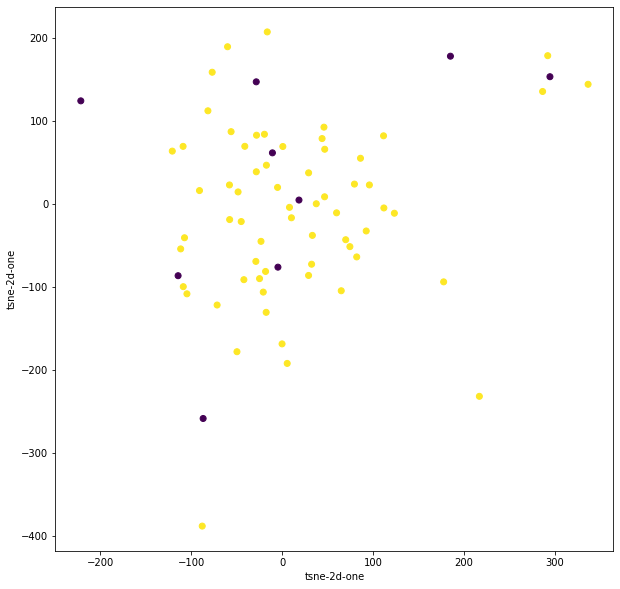

In [104]:
plt.figure(figsize=(10,10))
plt.scatter(df_subset['tsne-2d-one'],df_subset['tsne-2d-two'],c=df_subset['PI'])
plt.xlabel('tsne-2d-one')
plt.ylabel('tsne-2d-one')


In [40]:
tsne_results

array([[-2.2443347 , -4.706242  ],
       [ 4.034638  ,  2.8211336 ],
       [ 1.2392521 , -1.8968908 ],
       ...,
       [-5.816544  , -8.111503  ],
       [-0.77172625, -2.0545878 ],
       [-0.9246067 , -5.730704  ]], dtype=float32)